In [16]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random_deletion
import data_recovery
from importlib import reload

### Загрузим данные

In [7]:
creditg = pd.read_csv("dataset/credit-g.csv", header=1)
krkp = pd.read_csv("dataset/kr-vs-kp.csv", header=1)
segment = pd.read_csv("dataset/segment.csv", header=1)

#### KRKP

In [8]:
krkp.columns = ["col" + str(i) for i in range(1, 38)]

In [9]:
for i in range(1, 38):
    print(np.unique(krkp["col" + str(i)]))

['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['g' 'l']
['f' 't']
['b' 'n' 'w']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['f' 't']
['n' 't']
['nowin' 'won']


In [10]:
from sklearn.preprocessing import LabelEncoder

for i in range(1, 38):
    krkp["col" + str(i)] = LabelEncoder().fit_transform(krkp["col" + str(i)])

In [11]:
for i in range(1, 38):
    print(np.unique(krkp["col" + str(i)]))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1 2]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [12]:
krkp_y = krkp["col37"]
krkp.drop("col37", axis=1, inplace=True)

In [13]:
krkp = np.array(krkp, dtype='float')
krkp_y = np.array(krkp_y)

In [14]:
krkp

array([[ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.]])

##### 5 % пропущенных значений во всех объектах и всех признаках.

In [80]:
krkp_del = random_deletion.make_missing_value(krkp, del_fraction=0.05)

In [81]:
krkp_del

array([[  0.,   0.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       [  0.,   0.,   0., ...,   1.,   1.,   0.],
       ..., 
       [  1.,   0.,   0., ...,   1.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,  nan],
       [  1.,   0.,   1., ...,  nan,   0.,   0.]])

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score

In [83]:
cv = KFold(krkp_y.shape[0], n_folds=10, shuffle=True, random_state=798)
clf = RandomForestClassifier(n_jobs=-1, random_state=567)

##### 1. Без пропущенных значений.

In [84]:
print(np.mean(cross_val_score(clf, krkp, krkp_y, scoring='accuracy', cv=cv)))

0.989672805643


##### 2. Игнорируем объекты с пропущенными значениями.

In [85]:
krkp_del_ignore, krkp_y_ignore = data_recovery.ignore_imputer(krkp_del, krkp_y)

In [86]:
krkp_del_ignore.shape

(469, 36)

In [87]:
print(np.mean(cross_val_score(clf, krkp_del_ignore, krkp_y_ignore, scoring='accuracy', cv=10)))

0.899651171755


##### 3. Заполнение специальным значение (-1).

In [88]:
krkp_del_special = data_recovery.special_value_imputer(krkp_del, -1)

In [89]:
print(np.mean(cross_val_score(clf, krkp_del_special, krkp_y, scoring='accuracy', cv=cv)))

0.950859130094


##### 4. Заполнение самым частым значением.

In [90]:
krkp_del_common = data_recovery.common_value_imputer(krkp_del)

In [91]:
print(np.mean(cross_val_score(clf, krkp_del_common, krkp_y, scoring='accuracy', cv=cv)))

0.948048589342


##### 5. Заполнение с помощью SVD.

In [101]:
krkp_del_svd = data_recovery.svd_imputer(krkp_del, rank=16)

In [102]:
print(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=cv)))

0.95994612069


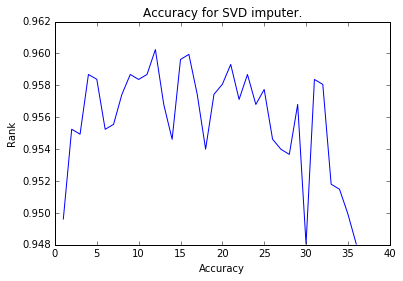

In [94]:
accuracy = []
for i in range(1, 37):
    krkp_del_svd = data_recovery.svd_imputer(krkp_del, rank=i)
    accuracy.append(np.mean(cross_val_score(clf, krkp_del_svd, krkp_y, scoring='accuracy', cv=cv)))

plt.plot(list(range(1, 37)), accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Rank")
plt.title("Accuracy for SVD imputer.")

##### 6. Заполнение с помощью kNN.

In [103]:
krkp_del_knn = data_recovery.knn_imputer(krkp_del, n_neighbors=3)

In [104]:
print(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=cv)))

0.953371865204


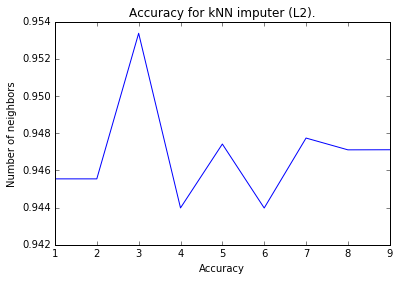

In [97]:
accuracy = []
for i in range(1, 10):
    krkp_del_knn = data_recovery.knn_imputer(krkp_del, n_neighbors=i)
    accuracy.append(np.mean(cross_val_score(clf, krkp_del_knn, krkp_y, scoring='accuracy', cv=cv)))

plt.plot(list(range(1, 10)), accuracy)
plt.xlabel("Accuracy")
plt.ylabel("Number of neighbors")
plt.title("Accuracy for kNN imputer (L2).")

### Сравним для разных долей пропущенных значений.

Пропущенные значения для всех объектов в _половине_ признаков. 

In [74]:
missing_frac_range = [0.05, 0.1, 0.15, 0.2, 0.25]
num_iter = 3

In [75]:
accuracy_ignore = []
accuracy_special = []
accuracy_common = []
accuracy_svd = []
accuracy_knn = []

rmse_ignore = []
rmse_special = []
rmse_common = []
rmse_svd = []
rmse_knn = []

In [76]:
for missing_frac in missing_frac_range:
    for iteration in range(num_iter):
        krkp_del = random_deletion.make_missing_value(krkp, del_fraction=missing_frac, del_fraction_column=0.5)
        
        # ignore
        krkp_tmp, krkp_del_y = data_recovery.ignore_imputer(krkp_del, krkp_y)
        if krkp_tmp.shape[0] > 10:
            accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_del_y, scoring='accuracy', cv=10))
        else:
            accuracy = 0
            
        if iteration == 0:
            accuracy_ignore.append(accuracy / num_iter)
        else:
            accuracy_ignore[-1] += accuracy / num_iter
            
        # special value
        krkp_tmp = data_recovery.special_value_imputer(krkp_del)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_special.append(accuracy / num_iter)
            rmse_special.append(rmse / num_iter)
        else:
            accuracy_special[-1] += accuracy / num_iter
            rmse_special[-1] += rmse / num_iter
            
        # common value
        krkp_tmp = data_recovery.common_value_imputer(krkp_del)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_common.append(accuracy / num_iter)
            rmse_common.append(rmse / num_iter)
        else:
            accuracy_common[-1] += accuracy / num_iter
            rmse_common[-1] += rmse / num_iter
            
        # svd
        krkp_tmp = data_recovery.svd_imputer(krkp_del, rank=20)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_svd.append(accuracy / num_iter)
            rmse_svd.append(rmse / num_iter)
        else:
            accuracy_svd[-1] += accuracy / num_iter
            rmse_svd[-1] += rmse / num_iter
            
        # knn
        krkp_tmp = data_recovery.knn_imputer(krkp_del, n_neighbors=5)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_knn.append(accuracy / num_iter)
            rmse_knn.append(rmse / num_iter)
        else:
            accuracy_knn[-1] += accuracy / num_iter
            rmse_knn[-1] += rmse / num_iter

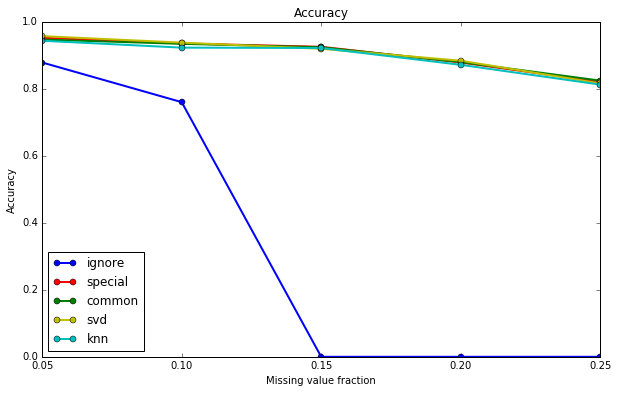

In [77]:
plt.figure(figsize=(10,6))
plt.title("Accuracy")
plt.plot(missing_frac_range, accuracy_ignore, 'bo-', label='ignore', lw=2)
plt.plot(missing_frac_range, accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, accuracy_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

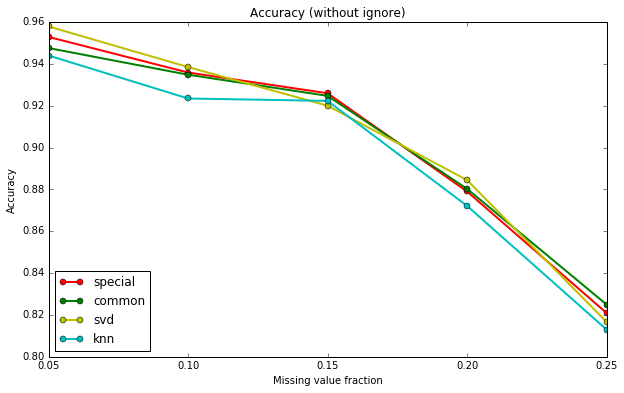

In [78]:
plt.figure(figsize=(10,6))
plt.title("Accuracy (without ignore)")
plt.plot(missing_frac_range, accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, accuracy_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

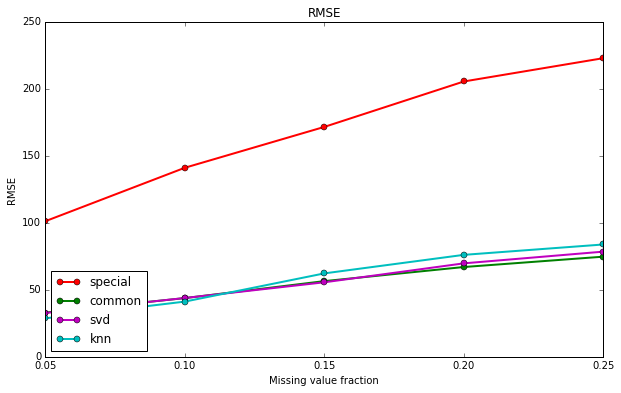

In [79]:
plt.figure(figsize=(10,6))
plt.title("RMSE")
plt.plot(missing_frac_range, rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, rmse_svd, 'mo-', label='svd', lw=2)
plt.plot(missing_frac_range, rmse_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")

Пропущенные значения для всех объектов во _всех_ признаках. 

In [112]:
accuracy_ignore = []
accuracy_special = []
accuracy_common = []
accuracy_svd = []
accuracy_knn = []

rmse_ignore = []
rmse_special = []
rmse_common = []
rmse_svd = []
rmse_knn = []

In [113]:
for missing_frac in missing_frac_range:
    for iteration in range(num_iter):
        krkp_del = random_deletion.make_missing_value(krkp, del_fraction=missing_frac, del_fraction_column=1.0)
        
        # ignore
        krkp_tmp, krkp_del_y = data_recovery.ignore_imputer(krkp_del, krkp_y)
        if krkp_tmp.shape[0] > 20:
            accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_del_y, scoring='accuracy', cv=10))
        else:
            accuracy = 0
            
        if iteration == 0:
            accuracy_ignore.append(accuracy / num_iter)
        else:
            accuracy_ignore[-1] += accuracy / num_iter
            
        # special value
        krkp_tmp = data_recovery.special_value_imputer(krkp_del)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_special.append(accuracy / num_iter)
            rmse_special.append(rmse / num_iter)
        else:
            accuracy_special[-1] += accuracy / num_iter
            rmse_special[-1] += rmse / num_iter
            
        # common value
        krkp_tmp = data_recovery.common_value_imputer(krkp_del)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_common.append(accuracy / num_iter)
            rmse_common.append(rmse / num_iter)
        else:
            accuracy_common[-1] += accuracy / num_iter
            rmse_common[-1] += rmse / num_iter
            
        # svd
        krkp_tmp = data_recovery.svd_imputer(krkp_del, rank=20)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_svd.append(accuracy / num_iter)
            rmse_svd.append(rmse / num_iter)
        else:
            accuracy_svd[-1] += accuracy / num_iter
            rmse_svd[-1] += rmse / num_iter
            
        # knn
        krkp_tmp = data_recovery.knn_imputer(krkp_del, n_neighbors=5)
        accuracy = np.mean(cross_val_score(clf, krkp_tmp, krkp_y, scoring='accuracy', cv=cv))
        rmse = np.sum((krkp - krkp_tmp) ** 2) ** 0.5
        if iteration == 0:
            accuracy_knn.append(accuracy / num_iter)
            rmse_knn.append(rmse / num_iter)
        else:
            accuracy_knn[-1] += accuracy / num_iter
            rmse_knn[-1] += rmse / num_iter

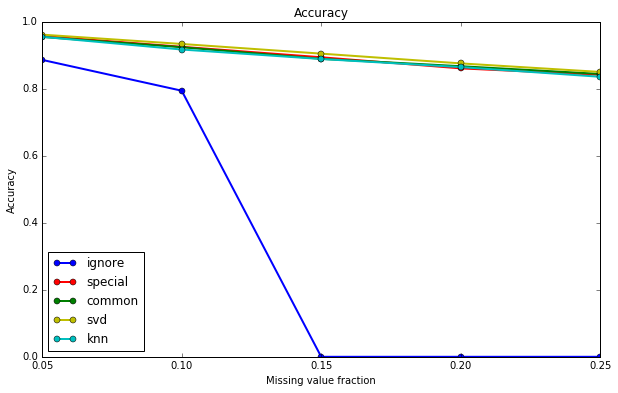

In [114]:
plt.figure(figsize=(10,6))
plt.title("Accuracy")
plt.plot(missing_frac_range, accuracy_ignore, 'bo-', label='ignore', lw=2)
plt.plot(missing_frac_range, accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, accuracy_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

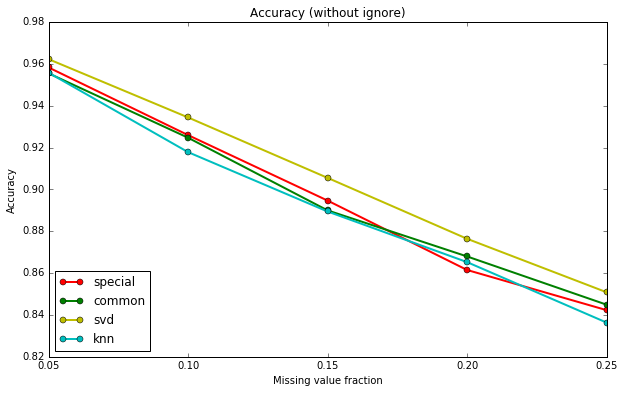

In [115]:
plt.figure(figsize=(10,6))
plt.title("Accuracy (without ignore)")
plt.plot(missing_frac_range, accuracy_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, accuracy_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, accuracy_svd, 'yo-', label='svd', lw=2)
plt.plot(missing_frac_range, accuracy_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("Accuracy")

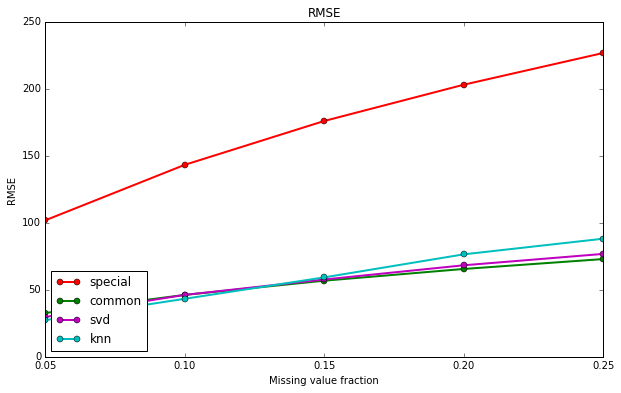

In [116]:
plt.figure(figsize=(10,6))
plt.title("RMSE")
plt.plot(missing_frac_range, rmse_special, 'ro-', label='special', lw=2)
plt.plot(missing_frac_range, rmse_common, 'go-', label='common', lw=2)
plt.plot(missing_frac_range, rmse_svd, 'mo-', label='svd', lw=2)
plt.plot(missing_frac_range, rmse_knn, 'co-', label='knn', lw=2)
plt.legend(loc='lower left')
plt.xlabel("Missing value fraction")
plt.ylabel("RMSE")